In [268]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from osgeo import gdal, osr


# Caminhos dos arquivos
base_path = r"/home/henrique/Documents/tif_proj"
raster_dir_path = os.path.join(base_path, "files_raster")
shape_dir_path = os.path.join(base_path, "shape_file")

tif_file_path = os.path.join(raster_dir_path, "gebco_2024_n0.0_s-90.0_w-90.0_e0.0.tif")
crop_tif_file_path = os.path.join(raster_dir_path, "crop.tif")
shape_file_path = os.path.join(shape_dir_path, "CE_Municipios_2022.shp")

In [228]:
from raster_handler.handler import Handler

In [229]:
def mergesort_clusters(arr):
    if len(arr) <= 1:
        return arr
    
    mid = len(arr) // 2
    left = mergesort_clusters(arr[:mid])
    right = mergesort_clusters(arr[mid:])
    
    return merge(left, right)

def merge(left, right):
    array_ordenado = []
    
    i = j = 0
    
    while i < len(left) and j < len(right):
        if len(left[i]) > len(right[j]):
            
            array_ordenado.append(left[i])
            i += 1
        else:
            array_ordenado.append(right[j])
            j += 1
    
    array_ordenado.extend(left[i:])
    array_ordenado.extend(right[j:])
    
    return array_ordenado

In [230]:
# Tif completo do gebco
handler_tif = Handler(tif_file_path)

# Recortar tif usando shape file
cropMatrix = handler_tif.getCrop(shape_file_path)

# Cerca de Tukey, log

In [231]:
# massa de dados sem NoData
dataset = cropMatrix.flatten()
dataset = dataset[dataset > 0]

In [42]:
print(min(dataset))

1


In [232]:
# Quartils 
Q1 = np.percentile(dataset, 25)
Q2 = np.percentile(dataset, 50)
Q3 = np.percentile(dataset, 75)

# IQR

IQR = Q3 - Q1

print(IQR)

309.0


In [233]:
alfa = 0.35

# limiete superior

limSup = Q3 +  alfa * IQR

# limite inferior

limInf = Q1 - alfa * IQR
print(f"Limite superior: {limSup}")
print(f"Limite inferior: {limInf}")

Limite superior: 532.15
Limite inferior: 6.8500000000000085


In [236]:
# dicionário de pontos do limite superior

dictLimSup = {}

for x in range(cropMatrix.shape[0]):
    for y in range(cropMatrix.shape[1]):
        if cropMatrix[x, y] > limSup:
            dictLimSup[(x, y)] = cropMatrix[x, y]

In [127]:
print(len(dictLimSup))
print(limSup)

102037
532.15


In [235]:
# dicionário de pontos do limite inferior

dictLimInf = {}

for x in range(cropMatrix.shape[0]):
    for y in range(cropMatrix.shape[1]):
        if cropMatrix[x, y] < limInf and cropMatrix[x, y] > 0:
            dictLimInf[(x, y)] = cropMatrix[x, y]

In [129]:
print(len(dictLimInf))
print(limInf)

2851
6.8500000000000085


In [130]:
# porcentagem de cada um 

print(f"Porcentagem de coordenadas abaixo do limite inferior {len(dictLimInf)/ len(dataset) * 100}")

print(f"Porcentagem de coordenadas acima do limite superior {len(dictLimSup)/ len(dataset) * 100}")

Porcentagem de coordenadas abaixo do limite inferior 0.4077383038029355
Porcentagem de coordenadas acima do limite superior 14.592912418498818


In [237]:
from collections import deque

def findNeighbor(cord: tuple[int, int]) -> tuple[tuple[int, int], ...]:
    return ((cord[0] - 1, cord[1]), (cord[0] + 1, cord[1]), 
            (cord[0], cord[1] + 1), (cord[0], cord[1] - 1))

# BFS para preencher o cluster
def fillList(cord: tuple[int, int], cords: set[tuple[int, int]]) -> list[tuple[int, int]]:
    resList = []
    queue = deque([cord])
    cords.remove(cord)  # Remove diretamente do conjunto (O(1))

    while queue:
        thisCord = queue.popleft()  # O(1) em deque
        resList.append(thisCord)

        for nei in findNeighbor(thisCord):
            if nei in cords:  # Busca em set é O(1)
                queue.append(nei)
                cords.remove(nei)  # Remoção em set é O(1)

    return resList

def getListCluster(dictCordVal):
    # Transformando em set para busca e remoção rápidas
    coordenadas = set(dictCordVal.keys())

    listCluster = []
    while coordenadas:
        thisCord = next(iter(coordenadas))  # Obtém um elemento arbitrário de `set`
        cluster = fillList(thisCord, coordenadas)
        listCluster.append(cluster)

    listCluster = [lista  for lista in listCluster if len(lista) > 1]
    return listCluster


In [54]:
print(len(getListCluster(dictLimSup)))

448


## Plotar outliers

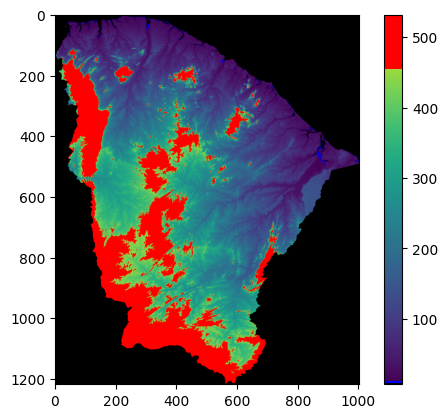

In [238]:
viridis = plt.get_cmap("viridis")

colors = viridis(np.linspace(0, 1, 256))

# porcentagem da alturas abaixo do limite inferior
porcentLimInf = len(dictLimInf)/len(dataset)
porcentLimSup = len(dictLimSup)/len(dataset)


indexInf = int(colors.shape[0] * (porcentLimInf))
indexSup = int(colors.shape[0] * (1 - porcentLimSup))

black = [0.0, 0.0, 0.0, 1.0]
azul = [0.0, 0.0, 1.0, 1.0]
vermelho = [1.0, 0.0, 0.0, 1.0]

colors[:indexInf] = azul
colors[indexSup:] = vermelho

extendend_colors = np.vstack([np.array(black), colors])

custom_cmap = mcolors.ListedColormap(extendend_colors)

norm = mcolors.Normalize(vmin=limInf, vmax=limSup)

fig, ax = plt.subplots()
cax = ax.imshow(cropMatrix, cmap=custom_cmap, norm=norm)
fig.colorbar(cax, ax=ax)
plt.show()


In [239]:
# a partir do chunks, gerar mpa com os cluster separados 

listClusterSup = mergesort_clusters(getListCluster(dictLimSup))
listClusterInf = mergesort_clusters(getListCluster(dictLimInf))


In [242]:
maioresInfLCusters = listClusterInf[:int(len(listClusterInf) * 0.1)]
print(len(maioresInfLCusters))


13


In [ ]:
maioresSupCusters = listClusterSup[:int(len(listClusterSup) * 0.1)]
print(len(maioresSupCusters))
maioresSupCusters.reverse()

42


## Plotar clusters

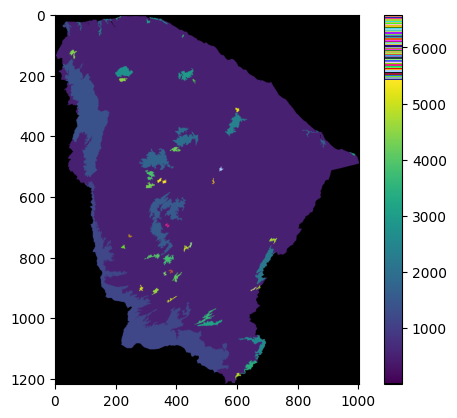

In [251]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def generate_random_colormap(name="random_colormap", n_colors=256):
    # Gera cores RGB aleatórias
    colors = np.random.rand(n_colors, 3)
    
    # Cria um colormap personalizado
    return LinearSegmentedColormap.from_list(name, colors, N=n_colors)

# Criando um colormap baseado no Viridis
viridis = plt.get_cmap("viridis")
colors = viridis(np.linspace(0, 1, 256))

black = [0.0, 0.0, 0.0, 1.0]  # Cor preta para representar algum limite

# Adicionando preto ao colormap base
extendend_colors = np.vstack([np.array(black), colors])

# Criando uma cópia da matriz original para modificar os clusters
plotMatrix = np.copy(cropMatrix)

plotMatrix[plotMatrix > 0] = 500

colormapAleatorio = generate_random_colormap(n_colors= (len(maioresSupCusters) + len(maioresInfLCusters)))

# Criando cores únicas para os clusters
colors = colormapAleatorio(np.linspace(0, 1, (len(maioresSupCusters) + len(maioresInfLCusters))))

# merge clusters

allClusters = []

m = j = 0
switch = False
while m < len(maioresInfLCusters) and j < len(maioresSupCusters):
    if switch:
        allClusters.append(maioresInfLCusters[m])
        m +=1 
        switch = not switch
    else:
        allClusters.append(maioresSupCusters[j])
        j += 1
        switch = not switch
        
allClusters.extend(maioresInfLCusters[m:])
allClusters.extend(maioresSupCusters[j:])
        
        

cluster_values = {}

i = 0

# Atribuindo valores únicos para cada cluster
for cluster in (allClusters):
    valor_cluster = np.max(dataset) + ((i + 1)*100)  # Criando valores únicos para clusters
    cluster_values[i] = valor_cluster
    i +=1
    for x, y in cluster:
        plotMatrix[x, y] = valor_cluster  # Modificando os valores dos clusters

# Adicionando as cores dos clusters ao colormap
extended_colors = np.vstack([extendend_colors, colors])

max_value = np.max(plotMatrix.flatten())

# Criando um novo colormap com as cores dos clusters incluídas
custom_cmap = mcolors.ListedColormap(extended_colors)

# Normalizando o colormap para incluir os valores dos clusters
norm = mcolors.Normalize(vmin=min(dataset) , vmax=max_value)

# Criando a figura e o gráfico
fig, ax = plt.subplots()
cax = ax.imshow(plotMatrix, cmap=custom_cmap, norm=norm)  # Usando plotMatrix corrigido
fig.colorbar(cax, ax=ax)
plt.show()

print()


## máximo e mínimo dos clusters

In [254]:
# para os clusters de outliers acima do limite máximo:
listtMaxPoints = []

for i, cluster in enumerate(maioresSupCusters):
    listtMaxPoints.append(cluster[0])
    for cord in cluster:
        if dictLimSup[cord] > dictLimSup[listtMaxPoints[i]]:
            listtMaxPoints[i] = cord

In [258]:
# para os clusters de outliers abaixo do limite mínimo:
listtMinPoints = []

for i, cluster in enumerate(maioresInfLCusters):
    listtMinPoints.append(cluster[0])
    for cord in cluster:
        if dictLimInf[cord] < dictLimInf[listtMinPoints[i]]:
            listtMaxPoints[i] = cord

## Criar imagem com os pontos

In [261]:
# A partir da matriz fatiada (cropMatriz) cria-se ua imagemonde:
# valor de número 0 é nodata
# valor de número 1 é terreno do ceará irrelevante
# valor de número 2 é nascente
# valor de número 3 é desagua

matrizResul = np.copy(cropMatrix)
matrizResul[matrizResul < 1] = 0
matrizResul[matrizResul >= 1] = 1

# pontos de máximo
for cord in listtMaxPoints:
    matrizResul[cord] = 2

for cord in listtMinPoints:
    matrizResul[cord] = 3 


In [264]:
nrows, ncols = matrizResul.shape

In [275]:
from osgeo import gdal, osr
import os
import numpy as np

# Defina o caminho de saída
caminho_raster = os.path.join(raster_dir_path, "min_max_points.tif")

# Obtenha o driver para GeoTIFF
driver = gdal.GetDriverByName("GTiff")

# Criar dataset GeoTIFF
data_set = driver.Create(caminho_raster, ncols, nrows, 1, gdal.GDT_Byte)

if data_set is None:
    raise RuntimeError("Erro ao criar o arquivo TIFF.")

# Definir a transformação geoespacial
data_set.SetGeoTransform(handler_tif.dataset.GetGeoTransform())

# Definir projeção
projecao = handler_tif.dataset.GetProjection()
if not projecao:
    raise ValueError("Projeção inválida ou não encontrada no dataset de origem.")

srs = osr.SpatialReference()
srs.ImportFromWkt(projecao)
data_set.SetProjection(srs.ExportToWkt())

# Escrever os dados da matriz
matrizResul = np.array(matrizResul, dtype=np.uint8)  # Certifica que os dados são do tipo correto
data_set.GetRasterBand(1).WriteArray(matrizResul)
data_set.GetRasterBand(1).SetNoDataValue(0)

# Salvar e fechar o dataset
data_set.FlushCache()
data_set = None  # Libera memória corretamente


In [278]:
dataset_reaberto = gdal.Open(caminho_raster, gdal.GA_ReadOnly)
banda = dataset_reaberto.GetRasterBand(1)

if banda is None:
    raise RuntimeError("Erro ao acessar a banda do arquivo TIFF.")


In [280]:
print(banda.ReadAsArray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
